**Transfer Learning**

In [1]:
import torch
print(torch.__version__)

2.8.0+cpu


In [2]:

device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


**Get Data**

In [3]:

import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


**Create Datasets and DataLoaders**

In [4]:
# training testing directory
train_dir=image_path/'train'
test_dir=image_path/'test'

print(train_dir)
print(test_dir)

data\pizza_steak_sushi\train
data\pizza_steak_sushi\test


In [5]:
# transforming the data for TL model
# all the pre-trained models expect data transformation in the same way
# 1. resizing of 224x224 (height, width) with RGB color channel 3
# 2. loading images in the range of [0,1], i.e transforms.ToTensor()
# 3. normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

# creating a manual transform
from torchvision import transforms
data_transforms=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [6]:
# what if we want to use the auto transform
# the required setting of the pre trained model

# Get a set of pre-trained model weights
import torchvision
# getting the best availabel weights
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
print(weights)

EfficientNet_B0_Weights.IMAGENET1K_V1


In [7]:
# making auto-transform
auto_transforms=weights.transforms()
print(auto_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [8]:
# making training, testing datasets
from torchvision import datasets

# using auto_transforms
train_data=datasets.ImageFolder(root=train_dir,transform=auto_transforms,target_transform=None)
test_data=datasets.ImageFolder(root=test_dir,transform=auto_transforms,target_transform=None)

print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )


In [9]:
# getting class names
class_names=train_data.classes
print(class_names)


['pizza', 'steak', 'sushi']


In [10]:
# creating training, testing dataloaders for models
from torch.utils.data import DataLoader

train_dataloader=DataLoader(dataset=train_data, batch_size=32, shuffle=True, num_workers=1)
test_dataloader=DataLoader(dataset=test_data,batch_size=32, shuffle=False,num_workers=1)

print(train_dataloader)
print(test_dataloader)

**setting up a pre-trained model**

*efficientnet_b0, trained on ImageNet dataset, is of 5.3 million parameters, across 1000 classes*

In [11]:
model_TL=torchvision.models.efficientnet_b0(weights=weights)
print(model_TL)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

*3 main component of this efficientnet_b0 model*

*1. features: A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images").*

*2. avgpool: Takes the average of the output of the features layer(s) and turns it into a feature vector.*

*3. classifier: Turns the feature vector into a vector with the same dimensionality as the number of required output classes (since efficientnet_b0 is pretrained on ImageNet and because ImageNet has 1000 classes, out_features=1000 is the default).*


Getting summary of model using `torchinfo.summary()`

inside the `torchinfo.summary()`, parameters are
1. `model`: model's summary
2. `input_size`: the shape of the data we'd like to pass to our model, for the case of efficientnet_b0, the input size is (batch_size, 3, 224, 224)
3. `col_names`: the various information columns we'd like to see about our model.
4. `col_wdith`: how width the column would be for summary
5. `row_settings`: what features should show in a row

In [12]:
from torchinfo import summary

summary(model=model_TL,input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

**Freezing the base model and changing the output layers according to our needs**

For freezing the base model, we need to freeze `features`, by setting attribute `requires_grad=False`.
For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` becomes 'untrainable' and 'frozen' in place.


In [13]:
# freezing base model
for param in model_TL.features.parameters():
    param.requires_grad=False
    

In [14]:
# changing the output_features form 1000 to 3 (pizza, sushi, steak)
torch.manual_seed(42)

output_shape=len(class_names)

model_TL.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape,bias=True).to(device)
)

In [15]:
# getting the summary after freezing and changing output layers
summary(model=model_TL,input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

**Train Model**

*loss function and optimizer*

In [16]:
from torch import nn
loss_fn=nn.CrossEntropyLoss()
optimizer_fn=torch.optim.Adam(params=model_TL.parameters(), lr=0.001)

*train_step*

In [29]:
def train_step(model:nn.Module,
               train_dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.modules,
               optimizer_fn:torch.optim.Optimizer,
               device:torch.device=device
               ):
    # model -> train
    model.train()
    train_loss=0
    train_accuracy=0

    for batch, (X,y) in enumerate(train_dataloader):
        X=X.to(device)
        y=y.to(device)

        y_pred=model(X) # forward pass
        loss= loss_fn(y_pred,y) # loss
        train_loss+=loss.item()
        optimizer_fn.zero_grad() # zero grad
        loss.backward() # back propagation
        optimizer_fn.step() # updation

        # calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_accuracy += (y_pred_class == y).sum().item()/len(y_pred)
    
    train_loss/=len(train_dataloader)
    train_accuracy/=len(train_dataloader)
    return train_loss, train_accuracy



*test_step*

In [30]:
def test_step(model:nn.Module,
              test_dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module,
              device:torch.device=device
              ):
    
    # model -> testing
    model.eval()
    test_loss=0
    test_accuracy=0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader):
            X=X.to(device)
            y=y.to(device)

            test_pred=model(X) # forward pass
            loss=loss_fn(test_pred,y) # loss function
            test_loss+=loss.item() 

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_accuracy += ((test_pred_labels == y).sum().item() /
                            len(test_pred_labels))
    test_loss/=len(test_dataloader)
    test_accuracy/=len(test_dataloader)

    return test_loss, test_accuracy



*Model Training*

In [31]:
def model_train(model:nn.Module, 
                train_dataloader:torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                loss_fn:nn.Module,
                optimizer_fn:torch.optim.Optimizer,
                epochs:int,
                device:torch.device=device
                ):
    
    results = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': []
    }

    # getting train_loss, train_accuracy, test_loss, test_accuracy
    for epoch in range(epochs):
        train_loss, train_accuracy=train_step(model=model,train_dataloader=train_dataloader,loss_fn=loss_fn,optimizer_fn=optimizer_fn,device=device)
        test_loss, test_accuracy=test_step(model=model,test_dataloader=test_dataloader,loss_fn=loss_fn,device=device)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_accuracy: {train_accuracy:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_accuracy: {test_accuracy:.4f}"
        )

        results["train_loss"].append(train_loss.item() if isinstance(
            train_loss, torch.Tensor) else train_loss)
        results["train_accuracy"].append(train_accuracy.item() if isinstance(
            train_accuracy, torch.Tensor) else train_accuracy)
        results["test_loss"].append(test_loss.item() if isinstance(
            test_loss, torch.Tensor) else test_loss)
        results["test_accuracy"].append(test_accuracy.item() if isinstance(
            test_accuracy, torch.Tensor) else test_accuracy)
    
    return results
        

*model_TL training results*

In [32]:
model_TL_results=model_train(model=model_TL,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             optimizer_fn=optimizer_fn,
                             epochs=10,
                             device=device
                             )

model_TL_results

Epoch: 1 | train_loss: 0.8493 | train_accuracy: 0.7266 | test_loss: 0.7077 | test_accuracy: 0.8759
Epoch: 2 | train_loss: 0.6755 | train_accuracy: 0.8789 | test_loss: 0.6838 | test_accuracy: 0.7642
Epoch: 3 | train_loss: 0.6038 | train_accuracy: 0.8555 | test_loss: 0.6311 | test_accuracy: 0.8144
Epoch: 4 | train_loss: 0.6779 | train_accuracy: 0.7422 | test_loss: 0.6021 | test_accuracy: 0.8049
Epoch: 5 | train_loss: 0.5804 | train_accuracy: 0.7930 | test_loss: 0.5383 | test_accuracy: 0.8561
Epoch: 6 | train_loss: 0.5069 | train_accuracy: 0.9180 | test_loss: 0.4569 | test_accuracy: 0.8864
Epoch: 7 | train_loss: 0.5456 | train_accuracy: 0.8047 | test_loss: 0.4833 | test_accuracy: 0.8665
Epoch: 8 | train_loss: 0.4840 | train_accuracy: 0.8203 | test_loss: 0.4262 | test_accuracy: 0.8665
Epoch: 9 | train_loss: 0.3897 | train_accuracy: 0.9414 | test_loss: 0.4328 | test_accuracy: 0.8769
Epoch: 10 | train_loss: 0.5190 | train_accuracy: 0.7773 | test_loss: 0.4792 | test_accuracy: 0.8665


{'train_loss': [0.8493184372782707,
  0.6754588857293129,
  0.6038005910813808,
  0.6778623759746552,
  0.5804020017385483,
  0.5068934634327888,
  0.545562632381916,
  0.4839945286512375,
  0.389667771756649,
  0.5190010741353035],
 'train_accuracy': [0.7265625,
  0.87890625,
  0.85546875,
  0.7421875,
  0.79296875,
  0.91796875,
  0.8046875,
  0.8203125,
  0.94140625,
  0.77734375],
 'test_loss': [0.7077300945917765,
  0.6838210423787435,
  0.6310978333155314,
  0.6020872592926025,
  0.5382678310076395,
  0.45688627163569134,
  0.48325295249621075,
  0.42624584833780926,
  0.43283196290334064,
  0.4792093137900035],
 'test_accuracy': [0.8759469696969697,
  0.7642045454545454,
  0.8143939393939394,
  0.8049242424242425,
  0.8560606060606061,
  0.8863636363636364,
  0.8664772727272728,
  0.8664772727272728,
  0.8768939393939394,
  0.8664772727272728]}

**Make predictions on the image from the test set**

for making predictions from the input image, we've to ensure that, image has
*same shape, same datatype, same device, same trasnformation*


In [ ]:
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt

def pred_and_plot_image(model:nn.Module,
                        image_path:str,
                        class_names:List[str],
                        image_size:Tuple[int,int]=(224,224),
                        transform:torchvision.transforms=None,
                        device:torch.device=device
                        ):
    
    # opening image
    img=Image.open(image_path)

    # image transformation if not exists
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    
    model.to(device)
    with torch.inference_mode():
        transformed_img=image_transform(img).unsqueeze(dim=0)

        # making predictions
        target_img_pred=model(transformed_img.to(device))

    # target image prediction probablities
    target_image_pred_probs = torch.softmax(target_img_pred, dim=1)

    # prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

    
    

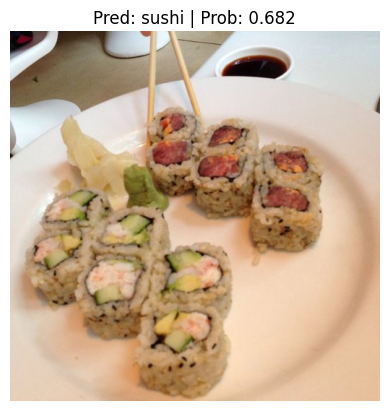

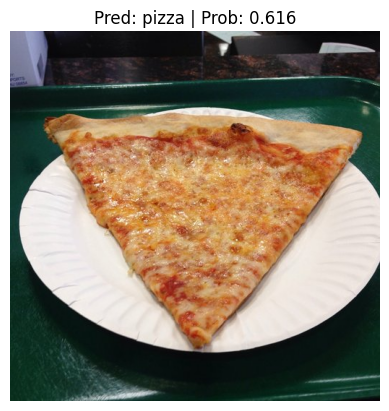

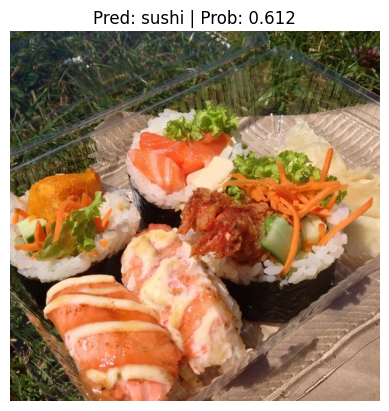

In [ ]:
# making predictions
import random
num_images_to_plot = 3
# get list all image paths from test data
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,  # go through all of the test image paths
                                       k=num_images_to_plot)  # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model_TL,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))
    
    


*predictions for custom images*

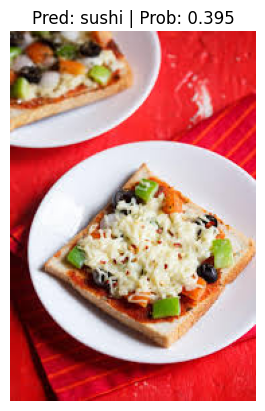

In [42]:
custom_data_path = Path("custom/")
custom_image_path = custom_data_path/'bread_pizza.jpg'

pred_and_plot_image(model=model_TL,image_path=custom_image_path,class_names=class_names,transform=weights.transforms())